In [24]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [25]:
   train_dir = 'PCB_Image_final/train/Open_circuit_bin'  
   output_dir = 'PCB_Image_final/train/Open_circuit_bin_output'  
  
   # Check if the train directory exists  
   if os.path.exists(train_dir):  
       print(f"Directory '{train_dir}' exists.")  
   else:  
       print(f"Directory '{train_dir}' does not exist.")  
  
   # Check if the output directory exists  
   if os.path.exists(output_dir):  
       print(f"Directory '{output_dir}' exists.")  
   else:  
       print(f"Directory '{output_dir}' does not exist.")  


Directory 'PCB_Image_final/train/Open_circuit_bin' exists.
Directory 'PCB_Image_final/train/Open_circuit_bin_output' exists.


In [426]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.sqrt(z_log_var) * epsilon

In [428]:
latent_dim = 7

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(1, (3,3), activation="softplus", strides=1, padding="same")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="softplus")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, activation="softplus", name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │         28 │ input_layer_44[0… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 16384)     │          0 │ conv2d_23[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 512)       │  8,389,120 │ flatten_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 7)         │      3,591 │ dense_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 7)         │      3,591 │ dense_65[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_23         │ (None, 7)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,396,330 (32.03 MB)

 Trainable params: 8,396,330 (32.03 MB)

 Non-trainable params: 0 (0.00 B)

In [429]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="softplus")(latent_inputs)
x = layers.Dense(128*128*1, activation="softplus")(x)
x = layers.Reshape((128,128,1))(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 512)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 16384)          │     8,404,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 128, 128, 3)    │            30 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,409,118 (32.08 MB)

 Trainable params: 8,409,118 (32.08 MB)

 Non-trainable params: 0 (0.00 B)

In [430]:
from keras.src.trainers.data_adapters import data_adapter_utils

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(y, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [431]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path):
    images = []

    for file in os.listdir(path):
        img = image.load_img(os.path.join(path, file), target_size=(128, 128, 3))
        images.append(image.img_to_array(img))
        
    return images

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(256, 256), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i]/255)

x_train = []
y_train = []
x_test = []
y_test = []

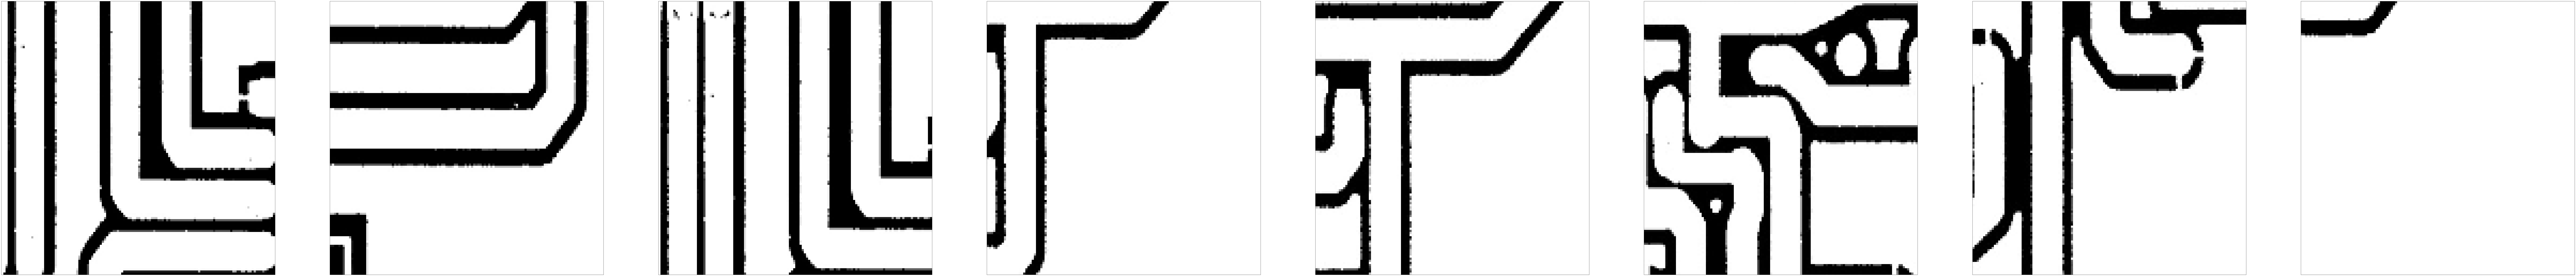

In [432]:
images = load_images_from_path('PCB_Image_final/Open_circuit_bin_resized')
show_images(images)
    
x_train += images

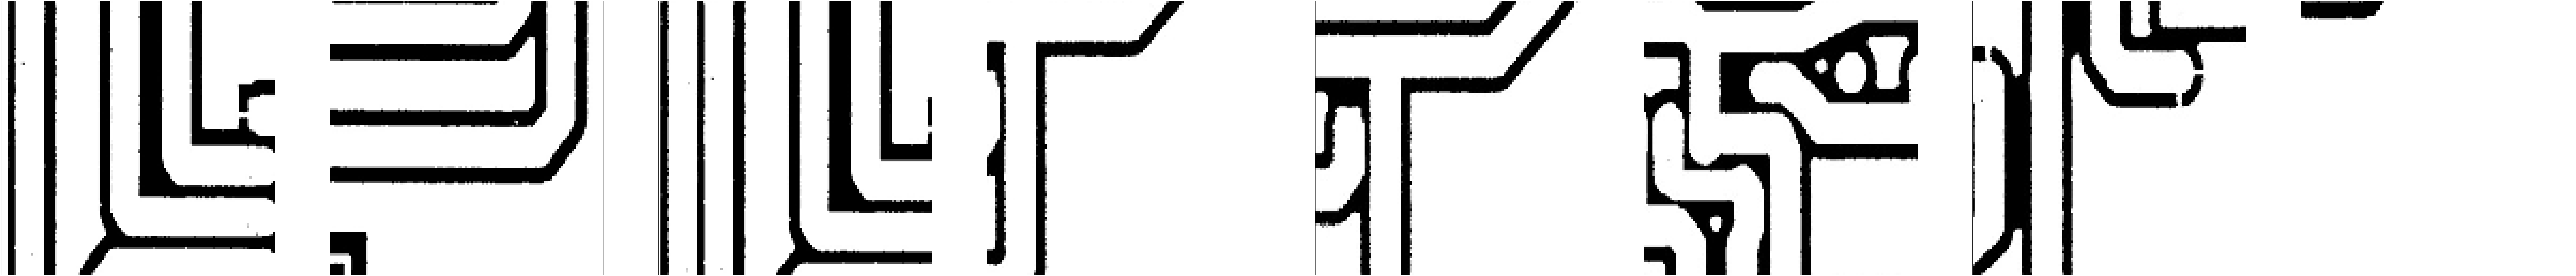

In [433]:
images = load_images_from_path('PCB_Image_final/Open_circuit_bin_output_resized')
show_images(images)
    
y_train += images

In [434]:
x_train = np.array(x_train)/255
y_train = np.array(y_train)/255

In [435]:
x_train.shape

(208, 128, 128, 3)

In [436]:
y_train.shape

(208, 128, 128, 3)

In [437]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
model = vae.fit(x_train, y_train, epochs=1000, batch_size=10)

Epoch 1/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - kl_loss: 273.3659 - loss: 11538.5264 - reconstruction_loss: 11265.1602
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - kl_loss: 3.9472 - loss: 10972.4727 - reconstruction_loss: 10968.5254
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - kl_loss: 11.3454 - loss: 10856.0889 - reconstruction_loss: 10844.7432
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - kl_loss: 54.7069 - loss: 10233.5059 - reconstruction_loss: 10178.7988
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - kl_loss: 58.3181 - loss: 9870.9893 - reconstruction_loss: 9812.6709
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - kl_loss: 47.9135 - loss: 9842.9795 - reconstruction_loss: 9795.0664
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - kl_loss: 49.8062 - loss: 9812.0918 - reconstruction_loss: 9762.2861
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - kl_loss: 64.5436 - loss: 9364.7930 - reconstruction_loss: 9300.2490


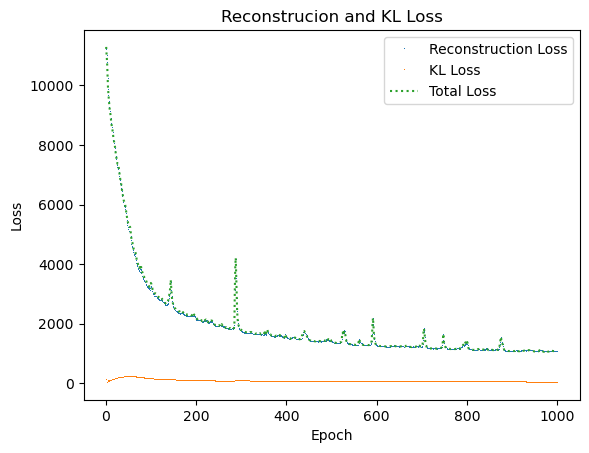

In [438]:
recon_loss = model.history['reconstruction_loss']
kl_loss = model.history['kl_loss']
total_loss = model.history['loss']
epochs = range(1,len(recon_loss)+1)

plt.plot(epochs, recon_loss, ',', label='Reconstruction Loss')
plt.plot(epochs, kl_loss, ',', label='KL Loss')
plt.plot(epochs, total_loss, ':',label='Total Loss')
plt.title('Reconstrucion and KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()
ax = plt.gca()

plt.savefig('Accuracy.png')

In [456]:
vae.build((None,128,128,3))

In [600]:
x_test = []

In [ ]:
images = load_images_from_path('PCB_Image_final/Open_circuit_bin_test')
    
x_test += images
x_test = np.array(x_test)/255
x_test

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [0.9607843 , 0.9607843 , 0.9607843 ]

In [602]:
z, _, _ = vae.encoder.predict(x_test)
predictions = vae.decoder.predict(z)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[[[0.99999845, 0.99999845, 0.99999845],
         [0.99999964, 0.99999964, 0.99999964],
         [0.99660915, 0.99660915, 0.99660915],
         ...,
         [0.9999955 , 0.9999955 , 0.9999955 ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.9999995 , 0.9999995 , 0.9999995 ],
         [0.99999994, 0.99999994, 0.99999994],
         [0.9978377 , 0.9978377 , 0.9978377 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.9999066 , 0.9999066 , 0.9999066 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[0.9999874 , 0.9999874 , 0.9999874 ],
         [1.        , 1.        , 1.        ]

[]

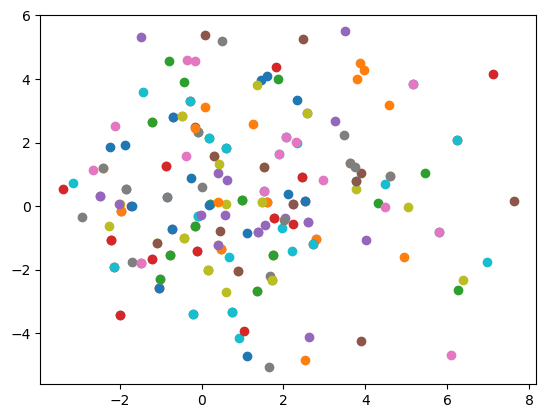

In [603]:
for i in range (len(z)) :
    plt.scatter(z[i][0],z[i][1])
plt.plot()

In [598]:
from PIL import Image
import numpy as np

for k in range(len(predictions)) :
    # Convert the pixels into an array using numpy
    array = np.array(predictions[k], dtype=np.float32)
    array = (array*255).astype(np.uint8)
    new_arr = [[] for i in range(128)]
    for i in range(len(array)) :
        for j in range(len(array[i])) :
            new_arr[i].append(max(array[i][j]))
    new_arr = np.asarray(new_arr)

    # Use PIL to create an image from the new array of pixels
    new_image = Image.fromarray(new_arr)
    new_image.save('PCB_Image_final/Open_circuit_test_output/output_' + str(k+1) + '.png')

In [499]:
for j in range(len(vae.encoder.layers)) :
    print("layer "+str(j))
    print(vae.encoder.layers[j].get_config())
    print(vae.encoder.layers[j].get_weights())

layer 0
{'batch_shape': (None, 128, 128, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_44'}
[]
layer 1
{'name': 'conv2d_23', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 1, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'softplus', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[[-0.45959815],
         [-0.19502094],
         [-0.05601963]],

        [[-0.09688961],
         [-0.48449177],
         [-0.40621072]]

[]

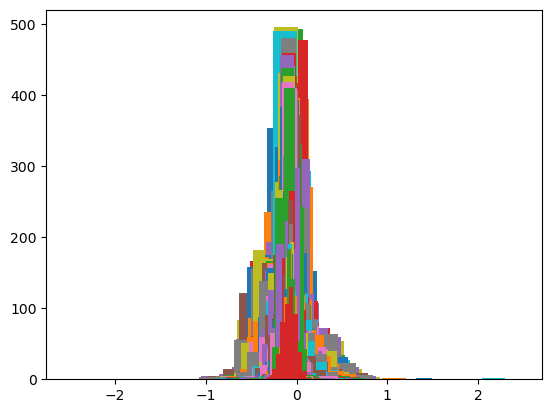

In [526]:
import matplotlib.pyplot as plt

for i in range (len(vae.encoder.layers[3].get_weights()[0])) :
    plt.hist(vae.encoder.layers[3].get_weights()[0][i])
plt.plot()

In [541]:
vae.encoder.layers[4].get_weights()[1]

array([-0.361592  ,  0.0323947 , -0.1980117 ,  0.3622503 , -0.25870454,
        0.16487655, -0.23878326], dtype=float32)

In [545]:
import matplotlib.pyplot as plt

f = open("latent_mean_weight.txt","w")
f.write("Layer Z mean\n")
f.close()
for i in range (len(vae.encoder.layers[4].get_weights()[0])) :
    if i != (len(vae.encoder.layers[4].get_weights()[0]) - 1) :
        f = open("latent_mean_weight.txt","a")
        f.write(str(vae.encoder.layers[4].get_weights()[0][i]) + "\n")
        f.close()
    else :
        f = open("latent_mean_weight.txt","a")
        f.write(str(vae.encoder.layers[4].get_weights()[0][i]))
        f.close()

In [546]:
f = open("latent_mean_bias.txt","w")
f.write("Layer Z mean\n")
f.close()
f = open("latent_mean_bias.txt","a")
f.write(str(vae.encoder.layers[4].get_weights()[1]))
f.close()

In [548]:
f = open("latent_variance_bias.txt","w")
f.write("Layer Z Variance\n")
f.close()
f = open("latent_variance_bias.txt","a")
f.write(str(vae.encoder.layers[5].get_weights()[1]))
f.close()

In [547]:
f = open("latent_variance_weight.txt","w")
f.write("Layer Z Variance\n")
f.close()
for i in range (len(vae.encoder.layers[5].get_weights()[0])) :
    if i != (len(vae.encoder.layers[5].get_weights()[0]) - 1) :
        f = open("latent_variance_weight.txt","a")
        f.write(str(vae.encoder.layers[5].get_weights()[0][i]) + "\n")
        f.close()
    else :
        f = open("latent_variance_weight.txt","a")
        f.write(str(vae.encoder.layers[5].get_weights()[0][i]))
        f.close()

In [549]:
f = open("encoder_dense_weight.txt","w")
f.write("Layer Dense Encoder\n")
f.close()
for i in range (len(vae.encoder.layers[3].get_weights()[0])) :
    if i != (len(vae.encoder.layers[3].get_weights()[0]) - 1) :
        f = open("encoder_dense_weight.txt","a")
        f.write(str(vae.encoder.layers[3].get_weights()[0][i]) + "\n")
        f.close()
    else :
        f = open("encoder_dense_weight.txt","a")
        f.write(str(vae.encoder.layers[3].get_weights()[0][i]))
        f.close()

In [551]:
f = open("encoder_dense_bias.txt","w")
f.write("Layer Dense Encoder\n")
f.close()
f = open("encoder_dense_bias.txt","a")
f.write(str(vae.encoder.layers[3].get_weights()[1]))
f.close()

In [557]:
f = open("encoder_conv_weight.txt","w")
f.write("Layer Conv Encoder\n")
f.close()
for i in range (len(vae.encoder.layers[1].get_weights()[0])) :
    if i != (len(vae.encoder.layers[1].get_weights()[0]) - 1) :
        f = open("encoder_conv_weight.txt","a")
        f.write(str(vae.encoder.layers[1].get_weights()[0][i]) + "\n")
        f.close()
    else :
        f = open("encoder_conv_weight.txt","a")
        f.write(str(vae.encoder.layers[1].get_weights()[0][i]))
        f.close()

In [558]:
f = open("encoder_conv_bias.txt","w")
f.write("Layer Conv Encoder\n")
f.close()
f = open("encoder_conv_bias.txt","a")
f.write(str(vae.encoder.layers[1].get_weights()[1]))
f.close()

In [498]:
for k in range(len(vae.decoder.layers)) :
    print("layer "+str(k))
    print(vae.decoder.layers[k].get_config())
    print(vae.decoder.layers[k].get_weights())

layer 0
{'batch_shape': (None, 7), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_45'}
[]
layer 1
{'name': 'dense_66', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 512, 'activation': 'softplus', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[ 0.59658813, -1.2303975 , -0.3961701 , ..., -0.44951975,
         0.31614757, -0.21526574],
       [-0.21235655,  0.7674713 , -0.06798565, ...,  0.88163596,
         0.06725753,  0.4399011 ],
       [ 0.68848556, -0.11466462, -0.03199568, ..., -0.82244426,
         0.3873827 , -0.9564342 ],
       ...,
     

In [559]:
f = open("decoder_dense1_weight.txt","w")
f.write("Layer Dense 1 decoder\n")
f.close()
for i in range (len(vae.decoder.layers[1].get_weights()[0])) :
    if i != (len(vae.decoder.layers[1].get_weights()[0]) - 1) :
        f = open("decoder_dense1_weight.txt","a")
        f.write(str(vae.decoder.layers[1].get_weights()[0][i]) + "\n")
        f.close()
    else :
        f = open("decoder_dense1_weight.txt","a")
        f.write(str(vae.decoder.layers[1].get_weights()[0][i]))
        f.close()

In [569]:
f = open("decoder_dense1_bias.txt","w")
f.write("Layer Dense 1 Decoder\n")
f.close()
f = open("decoder_dense1_bias.txt","a")
f.write(str(vae.decoder.layers[1].get_weights()[1]))
f.close()

In [576]:
np.savetxt("decoder_dense2_weight.txt", vae.decoder.layers[2].get_weights()[0], fmt='%.8e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)

In [572]:
f = open("decoder_dense2_weight.txt","w")
f.write("Layer Dense 2 decoder\n")
f.close()

In [571]:
f = open("decoder_dense2_weight.txt","w")
f.write("Layer Dense 2 decoder\n")
f.close()
f = open("decoder_dense2_weight.txt","a")
for i in range (len(vae.decoder.layers[2].get_weights()[0])) :
    if i != (len(vae.decoder.layers[2].get_weights()[0]) - 1) :
        for j in range (len(vae.decoder.layers[2].get_weights()[0][i])) :
            list = vae.decoder.layers[2].get_weights()[0][i]
            if j != (len(list)- 1) :
                f.write(str(list[j]) + ",")
            else : 
                f.write(str(list[j]))
        f.write("\n")
    else :
        for j in range (len(vae.decoder.layers[2].get_weights()[0][i])) :
            list = vae.decoder.layers[2].get_weights()[0][i]
            if j != (len(list) - 1) :
                f.write(str(list[j]) + ",")
            else : 
                f.write(str(list[j]))
f.close()

KeyboardInterrupt: 

In [581]:
f = open("decoder_dense2_bias.txt","w")
f.write("Layer Dense 2 decoder\n")
f.close()
for i in range (len(vae.decoder.layers[2].get_weights()[1])) :
    if i != (len(vae.decoder.layers[2].get_weights()[1]) - 1) :
        f = open("decoder_dense2_bias.txt","a")
        f.write(str(vae.decoder.layers[2].get_weights()[1][i]) + " ") 
        f.close()

In [579]:
f = open("decoder_conv_weight.txt","w")
f.write("Layer Conv Decoder\n")
f.close()
for i in range (len(vae.decoder.layers[4].get_weights()[0])) :
    if i != (len(vae.decoder.layers[4].get_weights()[0]) - 1) :
        f = open("decoder_conv_weight.txt","a")
        f.write(str(vae.decoder.layers[4].get_weights()[0][i]) + "\n")
        f.close()
    else :
        f = open("decoder_conv_weight.txt","a")
        f.write(str(vae.decoder.layers[4].get_weights()[0][i]))
        f.close()

In [580]:
f = open("decoder_conv_bias.txt","w")
f.write("Layer Conv Decoder\n")
f.close()
f = open("decoder_conv_bias.txt","a")
f.write(str(vae.decoder.layers[4].get_weights()[1]))
f.close()

In [43]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

InvalidArgumentError: Graph execution error:

Detected at node decoder_1/dense_4_1/BiasAdd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\Asus\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\Asus\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\Asus\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\Asus\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\Asus\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\Asus\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_1672\2468854629.py", line 38, in <module>

  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_1672\2468854629.py", line 17, in plot_latent_space

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 559, in predict

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 256, in one_step_on_data_distributed

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 246, in one_step_on_data

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 101, in predict_step

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 632, in call

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py", line 146, in call

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 168, in add

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\sparse.py", line 493, in sparse_wrapper

  File "c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 60, in add

Matrix size-incompatible: In[0]: [1,2], In[1]: [6,512]
	 [[{{node decoder_1/dense_4_1/BiasAdd}}]] [Op:__inference_one_step_on_data_distributed_214510]

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [36]:
jupyter server list

SyntaxError: invalid syntax (2236771642.py, line 1)